In [19]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
import pandas as pd

# Keras documentation can be found on keras.io:
import tensorflow.keras
from tensorflow.keras.datasets import mnist      # NOTE: This loads the data!
# manual link to data:  http://yann.lecun.com/exdb/mnist/
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, concatenate
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import glob
from PIL import Image

import tensorflow as tf
#import tf.compat.v1.train.AdamOptimizer as adam
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Data

In [23]:
file = './AppML_final_project/64_6x7k.npz'
data = np.load(file)

In [24]:
data['data'].shape

(42000, 64, 64)

In [25]:
train_images, val_images, train_labels, val_labels_ = train_test_split(data['data'], data['labels'], test_size=0.2, random_state=13052020)
val_images, test_images, val_labels, test_labels = train_test_split(val_images, val_labels_, test_size=0.2, random_state=13052020)

In [26]:
meta_train_images, meta_rest_images, meta_train_labels, meta_rest_labels = train_test_split(data['metadata'], data['labels'], test_size=0.2, random_state=13052020)
meta_val_images, meta_test_images, meta_val_labels, meta_test_labels = train_test_split(meta_rest_images, meta_rest_labels, test_size=0.2, random_state=13052020)

In [27]:
train_labels.shape

(33600, 1)

In [28]:
N = 64
# the data, split between train and testval sets
#(train_images, train_labels), (testval_images, testval_labels) = data.load_data()

# further split testval set into specific test and validation set
# the test set is NOT used during any part but inference
#train_images, val_images, train_labels, val_labels = train_test_split(testval_images, testval_labels, test_size=0.2, random_state=13052020)

# explicitly illustrating standardization
def standardizeimg(img, mu, sigma):
    return (img-mu)/(sigma).astype(np.float32)

# save for scaling test data
mu_train = np.mean(train_images)
sigma_train = np.std(train_images)

meta_mu = np.mean(meta_train_images)
meta_sigma = np.std(meta_train_images)

# Standardize pixel distribution to have zero mean and unit variance
train_images = standardizeimg(img=train_images, mu=mu_train, sigma=sigma_train)
val_images = standardizeimg(img=val_images, mu=np.mean(val_images), sigma=np.std(val_images))

meta_train_images = standardizeimg(img=meta_train_images, mu=meta_mu, sigma=meta_sigma)
meta_val_images = standardizeimg(img=meta_val_images, mu=np.mean(meta_val_images), sigma=np.std(meta_val_images))

# adapt to format required by tensorflow; Using channels_last --> (n_samples, img_rows, img_cols, n_channels)
img_rows, img_cols = N, N # input image dimensions
train_images = train_images.reshape(train_images.shape[0], img_rows, img_cols, 1)
val_images = val_images.reshape(val_images.shape[0], img_rows, img_cols, 1)

# convert class vectors to binary class matrices - one hot encoding
num_classes = 6
train_labels = tensorflow.keras.utils.to_categorical(train_labels, num_classes)
val_labels = tensorflow.keras.utils.to_categorical(val_labels, num_classes)

# avoid using statistics intrinsic to test data to ensure unbiased estimate of real model performance
test_images = standardizeimg(img=test_images, mu=mu_train, sigma=sigma_train)
meta_test_images = standardizeimg(meta_test_images,mu = meta_mu , sigma = meta_sigma)
test_images = test_images.reshape(test_images.shape[0], img_rows, img_cols, 1)
test_labels = tensorflow.keras.utils.to_categorical(test_labels, num_classes)

In [29]:
input_img = Input(shape = (img_rows, img_cols, 1))
input_meta = Input(shape = (39,))

In [30]:
33600*64*64

137625600

# Functions

In [38]:
def Make_model():    
    x = Conv2D(filters=32,
                     kernel_size=3,
                     strides=1,
                     padding='same',
                     activation='relu')(input_img)
    x = MaxPooling2D(pool_size=2, strides=None)(x)
    x = Conv2D(filters=64,
                     kernel_size=3,
                     strides=1,
                     padding='same',
                     activation='relu')(x)
    x = MaxPooling2D(pool_size=2, strides=None)(x)
    
    x = Dropout(rate=0.20)(x)
    
    x = Flatten()(x)
    x = Dense(units=128, activation='relu')(x) 
    x1 = Dense(128,activation = 'sigmoid')(input_meta) #New
    x = concatenate([x,x1])
    x = Dense(1024, activation = 'sigmoid')(x)
    
    output = Dense(units=num_classes, activation='sigmoid')(x)
    
    model = Model(inputs = [input_img ,input_meta], outputs = output)
    return model

In [32]:
#def CustomCCE(target, prediction, matrix=M):
##    print(prediction)
#    print(M)
#    tg = np.argmax(target.numpy(), axis=1)  ## THIS DOES NOT GENERALIZE TO BATCHSIZES > 1 
#    pg = np.argmax(prediction.numpy(), axis=1) ## THIS DOES NOT GENERALIZE TO BATCHSIZES > 1
#    
#    coeff = M[tg, pg]
#    cce = tf.keras.losses.CategoricalCrossentropy()
#    val = cce(target, prediction)
#    val = val*coeff
#    #print(f'Prediction: {pg} | actual: {tg} | loss: {val}')
#    return val

In [41]:
def CustomCCE(target, prediction):
        tg = np.argmax(target.numpy(), axis=1)
        pg = np.argmax(prediction.numpy(), axis=1)
        coeff = M[tg, pg]
        cce = tf.keras.losses.CategoricalCrossentropy()
        val = cce(target, prediction)
        val = val + coeff
        return val

In [75]:
def MakeConfMatrix(conf_matrix):
    error_rate = (np.sum(conf_matrix)-np.sum(np.diag(conf_matrix))) / np.sum(np.diag(conf_matrix))
    inf_acc = 1-error_rate
    plt.figure(figsize=(3,3))
    ax = sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 16}, fmt="d", linewidths=.5, square=True, cbar=False, cmap='Greens')
    ax.invert_yaxis()
    plt.ylabel('Actual label', fontsize=16)
    plt.xlabel('Predicted label', fontsize=16)
    plt.xticks(fontsize=14); plt.yticks(fontsize=14)
    plt.title('Accuracy Score: {:.4f}'.format(inf_acc), fontsize=16)
    plt.show()
    
    print('Correct: {0}/{1}'.format(np.sum(np.diag(conf_matrix)),np.sum(conf_matrix)))
    print('Wrong: {0}/{1}'.format((np.sum(conf_matrix)-np.sum(np.diag(conf_matrix))),np.sum(conf_matrix)))

In [78]:
conf_matrix = np.ones((3,3))

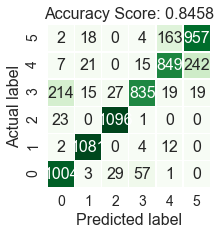

Correct: 5822/6720
Wrong: 898/6720


In [85]:
error_rate = (np.sum(conf_matrix)-np.sum(np.diag(conf_matrix))) / np.sum(np.diag(conf_matrix))
inf_acc = 1-error_rate
plt.figure(figsize=(3,3))
ax = sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 16}, fmt="d", linewidths=.5, square=True, cbar=False, cmap='Greens')
ax.invert_yaxis()
plt.ylabel('Actual label', fontsize=16)
plt.xlabel('Predicted label', fontsize=16)
plt.xticks(fontsize=14); plt.yticks(fontsize=14)
plt.title('Accuracy Score: {:.4f}'.format(inf_acc), fontsize=16)
plt.show()

print('Correct: {0}/{1}'.format(np.sum(np.diag(conf_matrix)),np.sum(conf_matrix)))
print('Wrong: {0}/{1}'.format((np.sum(conf_matrix)-np.sum(np.diag(conf_matrix))),np.sum(conf_matrix)))

In [87]:
conf_matrix

<tf.Tensor: shape=(6, 6), dtype=int32, numpy=
array([[1004,    3,   29,   57,    1,    0],
       [   2, 1081,    0,    4,   12,    0],
       [  23,    0, 1096,    1,    0,    0],
       [ 214,   15,   27,  835,   19,   19],
       [   7,   21,    0,   15,  849,  242],
       [   2,   18,    0,    4,  163,  957]])>

# Puts data in batches

In [43]:
batch_size = 100
N_batches = int(2400/batch_size)
train_images_batches = tf.split(train_images, N_batches)
train_meta_batches = tf.split(meta_train_images, N_batches)
train_image_labels_batches = tf.split(train_labels, N_batches)
train_meta_labels_batches = tf.split(meta_train_labels, N_batches)

# RIGHT HERE

In [39]:
model = Make_model()

In [44]:
print(val_images.shape)
print(meta_val_images.shape)


(6720, 64, 64, 1)
(6720, 39)


In [ ]:
#model = Make_model()

{'loss': 1.3379894495010376, 'categorical_crossentropy': 0.33798930048942566, 'categorical_accuracy': 0.8656250238418579, 'auc_5': 0.9526269435882568}
Conf_matrix


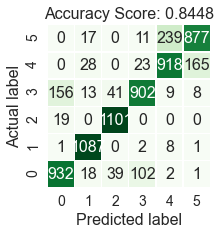

Correct: 5817/6720
Wrong: 903/6720
Weight matrix


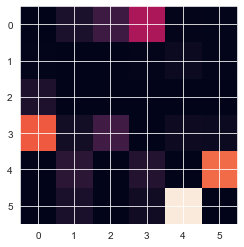

{'loss': 1.0397852659225464, 'categorical_crossentropy': 0.3066774308681488, 'categorical_accuracy': 0.8770833611488342, 'auc_5': 0.951440691947937}
Conf_matrix


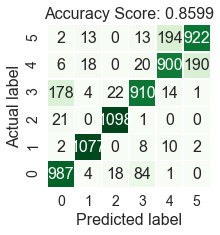

Correct: 5894/6720
Wrong: 826/6720
Weight matrix


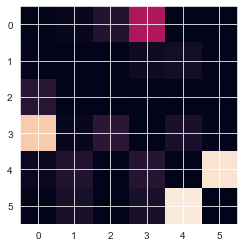

{'loss': 1.21613347530365, 'categorical_crossentropy': 0.30521976947784424, 'categorical_accuracy': 0.8757440447807312, 'auc_5': 0.9403413534164429}
Conf_matrix


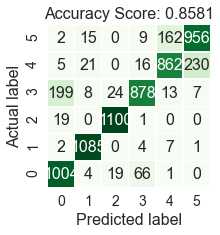

Correct: 5885/6720
Wrong: 835/6720
Weight matrix


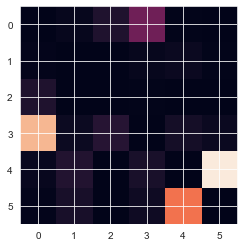

{'loss': 1.080880045890808, 'categorical_crossentropy': 0.30025801062583923, 'categorical_accuracy': 0.8778274059295654, 'auc_5': 0.9345529675483704}
Conf_matrix


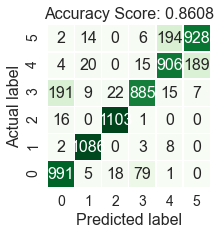

Correct: 5899/6720
Wrong: 821/6720
Weight matrix


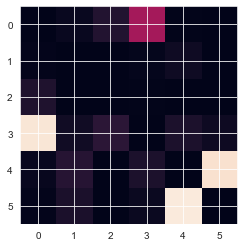

{'loss': 1.1867369413375854, 'categorical_crossentropy': 0.29857388138771057, 'categorical_accuracy': 0.8830357193946838, 'auc_5': 0.9312256574630737}
Conf_matrix


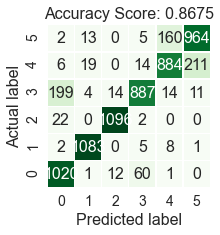

Correct: 5934/6720
Wrong: 786/6720
Weight matrix


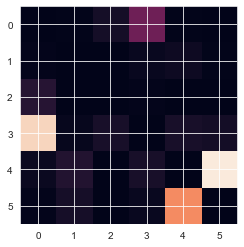

{'loss': 1.0947372913360596, 'categorical_crossentropy': 0.2945789396762848, 'categorical_accuracy': 0.8852678537368774, 'auc_5': 0.929883599281311}
Conf_matrix


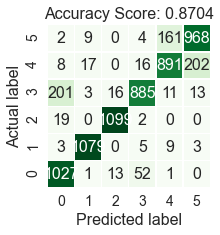

Correct: 5949/6720
Wrong: 771/6720
Weight matrix


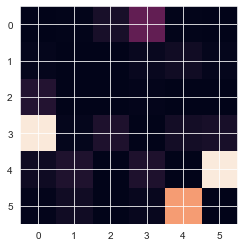

{'loss': 1.1001509428024292, 'categorical_crossentropy': 0.2947303354740143, 'categorical_accuracy': 0.8860118985176086, 'auc_5': 0.9278474450111389}
Conf_matrix


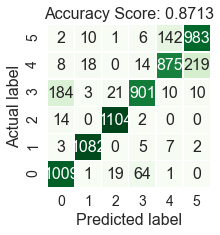

Correct: 5954/6720
Wrong: 766/6720
Weight matrix


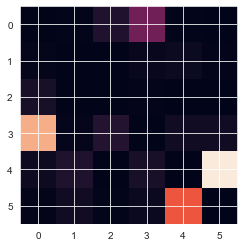

{'loss': 0.99433434009552, 'categorical_crossentropy': 0.2908048927783966, 'categorical_accuracy': 0.8863095045089722, 'auc_5': 0.9237094521522522}
Conf_matrix


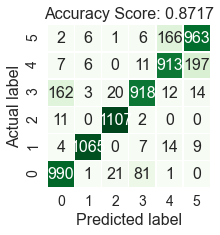

Correct: 5956/6720
Wrong: 764/6720
Weight matrix


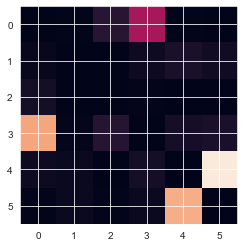

{'loss': 1.0649409294128418, 'categorical_crossentropy': 0.2930047810077667, 'categorical_accuracy': 0.8885416388511658, 'auc_5': 0.9252768158912659}
Conf_matrix


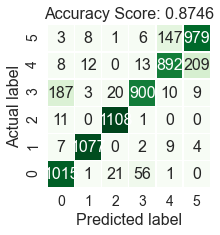

Correct: 5971/6720
Wrong: 749/6720
Weight matrix


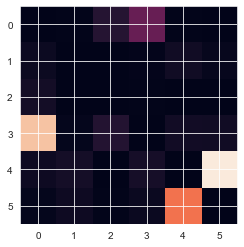

{'loss': 0.9894234538078308, 'categorical_crossentropy': 0.2833186388015747, 'categorical_accuracy': 0.8910714387893677, 'auc_5': 0.9200954437255859}
Conf_matrix


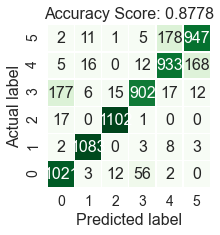

Correct: 5988/6720
Wrong: 732/6720
Weight matrix


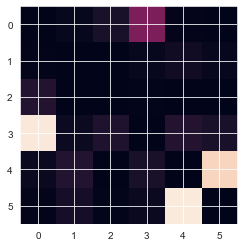

{'loss': 1.1010545492172241, 'categorical_crossentropy': 0.28531891107559204, 'categorical_accuracy': 0.8907738327980042, 'auc_5': 0.920870840549469}
Conf_matrix


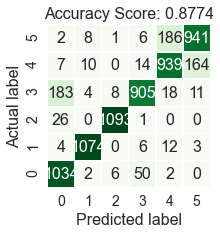

Correct: 5986/6720
Wrong: 734/6720
Weight matrix


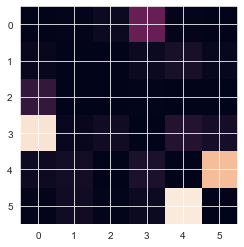

{'loss': 1.064111590385437, 'categorical_crossentropy': 0.3113672435283661, 'categorical_accuracy': 0.8785714507102966, 'auc_5': 0.9153375625610352}
Conf_matrix


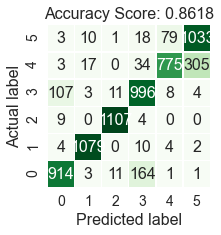

Correct: 5904/6720
Wrong: 816/6720
Weight matrix


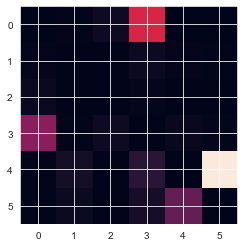

{'loss': 0.9640087485313416, 'categorical_crossentropy': 0.3111106753349304, 'categorical_accuracy': 0.8806547522544861, 'auc_5': 0.9119023084640503}
Conf_matrix


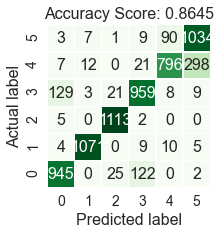

Correct: 5918/6720
Wrong: 802/6720
Weight matrix


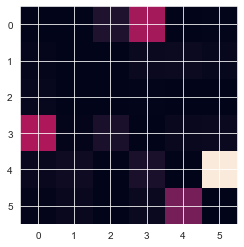

{'loss': 0.8633549809455872, 'categorical_crossentropy': 0.2995663583278656, 'categorical_accuracy': 0.8860118985176086, 'auc_5': 0.9110962152481079}
Conf_matrix


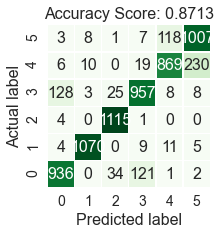

Correct: 5954/6720
Wrong: 766/6720
Weight matrix


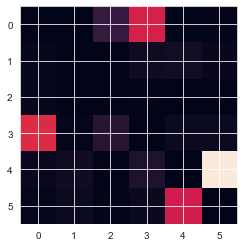

{'loss': 0.9918107390403748, 'categorical_crossentropy': 0.32711753249168396, 'categorical_accuracy': 0.8830357193946838, 'auc_5': 0.9034324884414673}
Conf_matrix


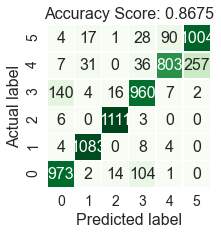

Correct: 5934/6720
Wrong: 786/6720
Weight matrix


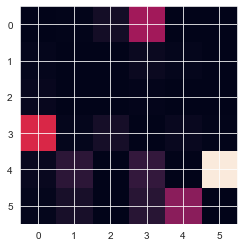

{'loss': 0.9328773617744446, 'categorical_crossentropy': 0.3580208122730255, 'categorical_accuracy': 0.8742559552192688, 'auc_5': 0.8920433521270752}
Conf_matrix


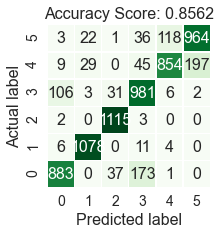

Correct: 5875/6720
Wrong: 845/6720
Weight matrix


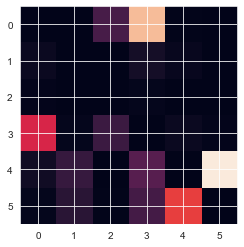

{'loss': 1.070356011390686, 'categorical_crossentropy': 0.325364351272583, 'categorical_accuracy': 0.883184552192688, 'auc_5': 0.899398922920227}
Conf_matrix


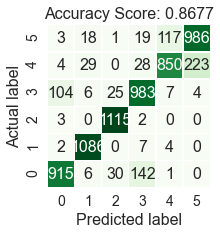

Correct: 5935/6720
Wrong: 785/6720
Weight matrix


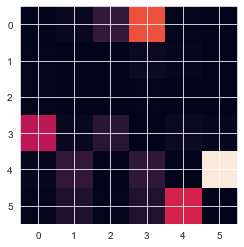

{'loss': 0.9835633635520935, 'categorical_crossentropy': 0.3088093400001526, 'categorical_accuracy': 0.8858630657196045, 'auc_5': 0.9122614860534668}
Conf_matrix


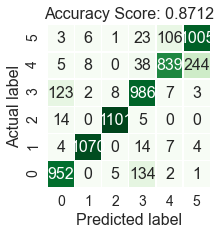

Correct: 5953/6720
Wrong: 767/6720
Weight matrix


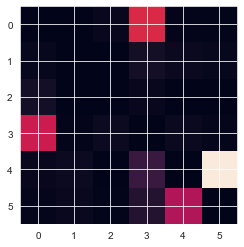

{'loss': 0.846361517906189, 'categorical_crossentropy': 0.30597570538520813, 'categorical_accuracy': 0.8938987851142883, 'auc_5': 0.9172340631484985}
Conf_matrix


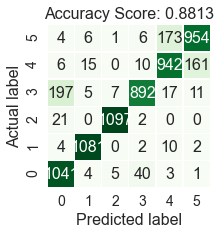

Correct: 6007/6720
Wrong: 713/6720
Weight matrix


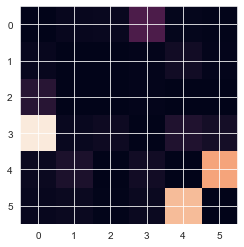

{'loss': 1.1015429496765137, 'categorical_crossentropy': 0.33786270022392273, 'categorical_accuracy': 0.8764880895614624, 'auc_5': 0.9086419939994812}
Conf_matrix


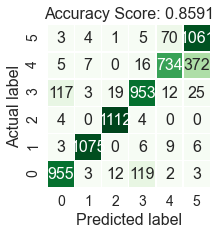

Correct: 5890/6720
Wrong: 830/6720
Weight matrix


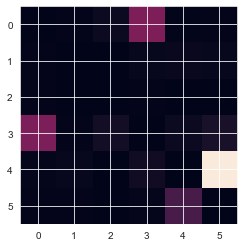

{'loss': 0.740547239780426, 'categorical_crossentropy': 0.309531569480896, 'categorical_accuracy': 0.8880952596664429, 'auc_5': 0.9101932644844055}
Conf_matrix


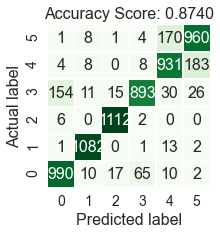

Correct: 5968/6720
Wrong: 752/6720
Weight matrix


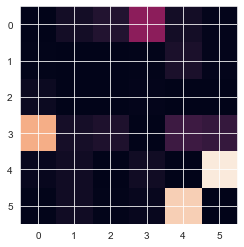

{'loss': 1.0518862009048462, 'categorical_crossentropy': 0.3213936686515808, 'categorical_accuracy': 0.893750011920929, 'auc_5': 0.9108350872993469}
Conf_matrix


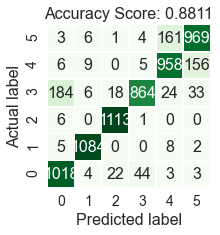

Correct: 6006/6720
Wrong: 714/6720
Weight matrix


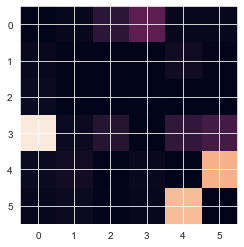

{'loss': 1.0978690385818481, 'categorical_crossentropy': 0.3320987820625305, 'categorical_accuracy': 0.8903273940086365, 'auc_5': 0.9143465161323547}
Conf_matrix


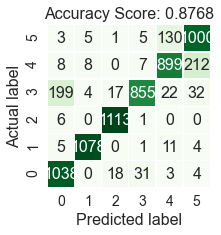

Correct: 5983/6720
Wrong: 737/6720
Weight matrix


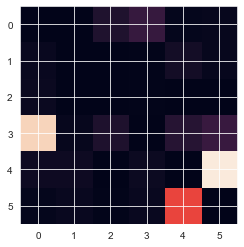

{'loss': 1.0197043418884277, 'categorical_crossentropy': 0.3392165005207062, 'categorical_accuracy': 0.8970237970352173, 'auc_5': 0.9154459238052368}
Conf_matrix


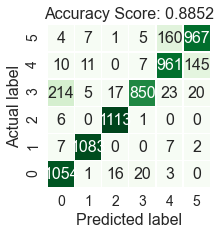

Correct: 6028/6720
Wrong: 692/6720
Weight matrix


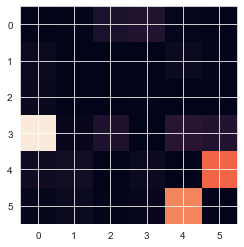

{'loss': 0.9199281930923462, 'categorical_crossentropy': 0.3024173378944397, 'categorical_accuracy': 0.898065447807312, 'auc_5': 0.9146591424942017}
Conf_matrix


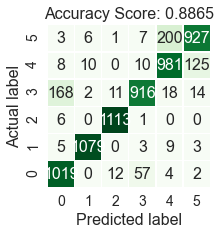

Correct: 6035/6720
Wrong: 685/6720
Weight matrix


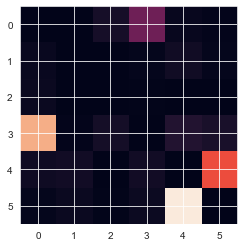

{'loss': 0.9930219650268555, 'categorical_crossentropy': 0.3197033703327179, 'categorical_accuracy': 0.8883928656578064, 'auc_5': 0.9055288434028625}
Conf_matrix


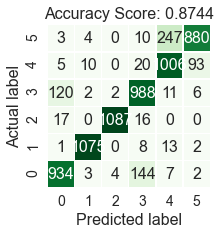

Correct: 5970/6720
Wrong: 750/6720
Weight matrix


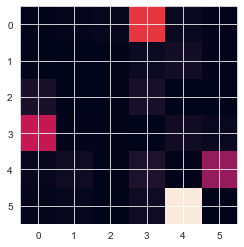

{'loss': 0.8298382759094238, 'categorical_crossentropy': 0.3200300931930542, 'categorical_accuracy': 0.8940476179122925, 'auc_5': 0.9050908088684082}
Conf_matrix


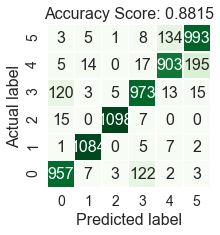

Correct: 6008/6720
Wrong: 712/6720
Weight matrix


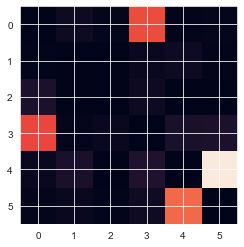

{'loss': 0.9860796332359314, 'categorical_crossentropy': 0.334728866815567, 'categorical_accuracy': 0.8967261910438538, 'auc_5': 0.9094157814979553}
Conf_matrix


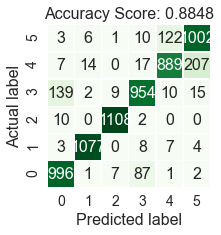

Correct: 6026/6720
Wrong: 694/6720
Weight matrix


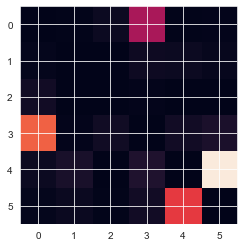

{'loss': 1.0049371719360352, 'categorical_crossentropy': 0.3512105643749237, 'categorical_accuracy': 0.8953869342803955, 'auc_5': 0.9116535782814026}
Conf_matrix


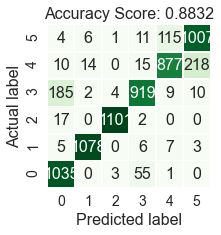

Correct: 6017/6720
Wrong: 703/6720
Weight matrix


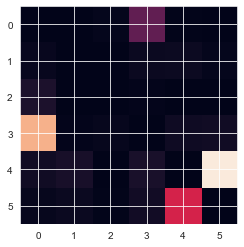

{'loss': 1.0378497838974, 'categorical_crossentropy': 0.3616807460784912, 'categorical_accuracy': 0.8901785612106323, 'auc_5': 0.9135103821754456}
Conf_matrix


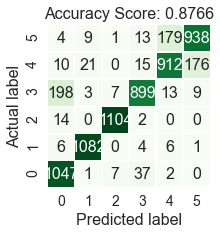

Correct: 5982/6720
Wrong: 738/6720
Weight matrix


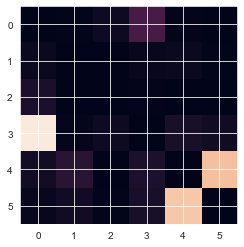

In [89]:
model.compile(loss = CustomCCE, optimizer = Adam(), run_eagerly=True,
              metrics = [tf.keras.metrics.CategoricalCrossentropy(), tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.AUC()])

M = np.ones((6,6))
N_epochs = 5
batch_size = 100
val_losses = [10**10]
val_CatAccs = []
patience = 0
while patience < 5:
    for epoch in range(N_epochs):
        for i in range(len(train_images_batches)):
            history = model.train_on_batch([train_images_batches[i], train_meta_batches[i]], train_image_labels_batches[i])
        val_metrics = model.evaluate(x=[val_images, meta_val_images], y=val_labels, verbose=0, return_dict=True)
        print(val_metrics)

        if val_metrics['loss'] < np.min(np.array(val_losses)):
            patience = 0
        else:
            patience +=1
        val_losses.append(val_metrics['loss'])
        val_CatAccs.append(val_metrics['categorical_accuracy'])
        
        predictions, truth = Predict([val_images, meta_val_images], val_labels, batch_size)
        
        conf_matrix = tf.math.confusion_matrix(labels=np.argmax(truth,axis=1), predictions=np.argmax(predictions,axis=1), num_classes=6)
                
        
        
        print('Conf_matrix')
        #plt.imshow(conf_matrix)
        #plt.show()
        MakeConfMatrix(conf_matrix)
        conf_matrix = np.array(conf_matrix)
        np.fill_diagonal(conf_matrix,0)
        M = conf_matrix/np.max(conf_matrix)*10
        print('Weight matrix')
        #MakeConfMatrix(tf.convert_to_tensor(M))
        plt.imshow(M)
        plt.show()

In [ ]:
def Predict(X, y, batch_size):
    pred = model.predict(X, batch_size=batch_size) # X= [X_img, X_meta]
    return pred, y

predictions, truth = Predict([val_images, meta_val_images], val_labels, batch_size=100)

In [ ]:
#prediction, truth = Predict([test_images, meta_test_images], meta_test_labels)

In [ ]:
predictions

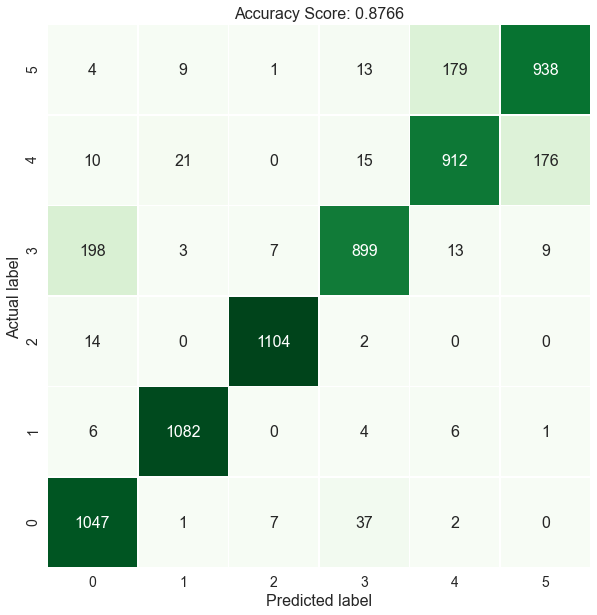

Correct: 5982/6720
Wrong: 738/6720


<Figure size 432x288 with 0 Axes>

In [90]:
conf_matrix = tf.math.confusion_matrix(labels=np.argmax(val_labels, axis=1), predictions=np.argmax(predictions, axis=1), num_classes=6)
error_rate = (np.sum(conf_matrix)-np.sum(np.diag(conf_matrix))) / np.sum(np.diag(conf_matrix))
inf_acc = 1-error_rate
plt.figure(figsize=(10,10))
ax = sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 16}, fmt="d", linewidths=.5, square=True, cbar=False, cmap='Greens')
ax.invert_yaxis()
plt.ylabel('Actual label', fontsize=16)
plt.xlabel('Predicted label', fontsize=16)
plt.xticks(fontsize=14); plt.yticks(fontsize=14)
plt.title('Accuracy Score: {:.4f}'.format(inf_acc), fontsize=16)
plt.show()

print('Correct: {0}/{1}'.format(np.sum(np.diag(conf_matrix)),np.sum(conf_matrix)))
print('Wrong: {0}/{1}'.format((np.sum(conf_matrix)-np.sum(np.diag(conf_matrix))),np.sum(conf_matrix)))
plt.savefig('confmatrix0.2.png', format='png')

In [91]:
conf_matrix = tf.math.confusion_matrix(labels=np.argmax(val_labels, axis=1), predictions=np.argmax(predictions, axis=1), num_classes=6)
print('Confusion Matrix: ', conf_matrix)

# Original code:
#sess = tf.compat.v1.InteractiveSession()
#conf_matrix = confusion.eval(session=sess)     # Needs update to new TF...
#sess.close()

# Accuracy score for inference
error_rate = (np.sum(conf_matrix)-np.sum(np.diag(conf_matrix))) / np.sum(np.diag(conf_matrix))
inf_acc = 1-error_rate

Confusion Matrix:  tf.Tensor(
[[1047    1    7   37    2    0]
 [   6 1082    0    4    6    1]
 [  14    0 1104    2    0    0]
 [ 198    3    7  899   13    9]
 [  10   21    0   15  912  176]
 [   4    9    1   13  179  938]], shape=(6, 6), dtype=int32)


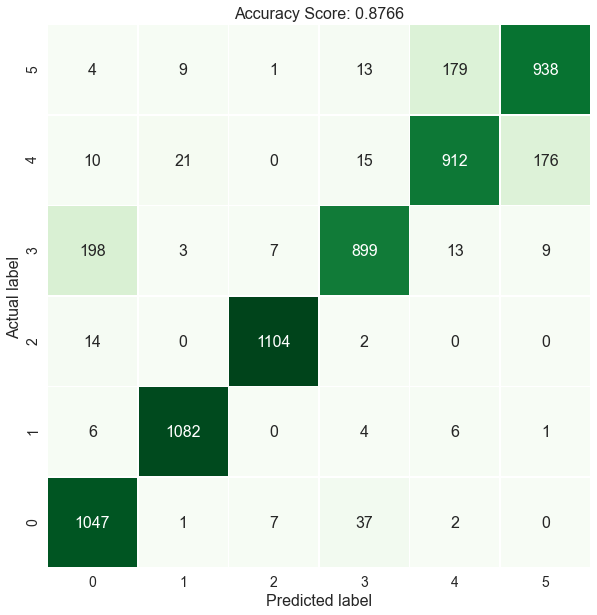

Correct: 5982/6720
Wrong: 738/6720


In [92]:
plt.figure(figsize=(10,10))
ax = sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 16}, fmt="d", linewidths=.5, square=True, cbar=False, cmap='Greens')
ax.invert_yaxis()
plt.ylabel('Actual label', fontsize=16)
plt.xlabel('Predicted label', fontsize=16)
plt.xticks(fontsize=14); plt.yticks(fontsize=14)
plt.title('Accuracy Score: {:.4f}'.format(inf_acc), fontsize=16)
plt.show()

print('Correct: {0}/{1}'.format(np.sum(np.diag(conf_matrix)),np.sum(conf_matrix)))
print('Wrong: {0}/{1}'.format((np.sum(conf_matrix)-np.sum(np.diag(conf_matrix))),np.sum(conf_matrix)))

# ROC

In [93]:
# Plotting the ROC curve, to test for overtaining and preformance
train_labels = tf.keras.utils.to_categorical(y_train, num_classes)
test_labels = tf.keras.utils.to_categorical(y_test, num_classes)

title = path

for i in range(num_classes):
    fig1, ax1 = plt.subplots(figsize=(6,6))
    fpr,tpr, threshold =sklearn.metrics.roc_curve(test_labels[:,i],ypred_test[:,i])
    ax1.plot(fpr,tpr,'b', label='Test: ROC curve')

    fpr_train,tpr_train, threshold_train =sklearn.metrics.roc_curve(train_labels[:,i],ypred_train[:,i])
    ax1.plot(fpr_train,tpr_train,'r', label='Train: ROC curve')
    ax1.plot(np.linspace(0,1,100),np.linspace(0,1,100),'g', label='1:1 curve')
    ax1.set(xlabel='False positive rate',ylabel='True postive rate',title=title[i])
    ax1.legend()


    # The AUC and accuracy is computed and printed in the figure
    auc_score_train = auc(fpr_train,tpr_train)   
    auc_score_test = auc(fpr,tpr)   

    acc_score_train = accuracy_score(train_labels[:,i],np.where(ypred_train[:,i] > 0.5, 1, 0))
    acc_score_test = accuracy_score(test_labels[:,i],np.where(ypred_test[:,i] > 0.5, 1, 0))

    row_labels=['Test',
            'Train']
    table_vals=[[round(auc_score_test,5),round(acc_score_test,5)],
            [round(auc_score_train,5),round(acc_score_train,5)]]
    col_labels=['AUC','Accuracy']
    the_table = ax1.table(cellText=table_vals,
                  colWidths = [0.19]*3,
                  rowLabels=row_labels,
                  colLabels=col_labels,
                  loc='center right')
    fig1.savefig('RUC_'+path[i]+'3type', dpi=750)
Aa



NameError: name 'y_train' is not defined